<h1 align='center'>Алгоритмы анализа данных</h1>

<h1 align='center'>Домашнее задание № 6</h1>

<h2 align='left'>Градиентный бустинг. AdaBoost</h2>

# <p style="background-color:lightgreen;font-family:newtimeroman;color:#662e2e;font-size:130%;text-align:center;border-radius:30px 30px;">Задача</p>

__1.__ Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

__2.__ *Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

__3.__ *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

__Решение:__

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [4]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [6]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [8]:
# Число деревьев в ансамбле
n_trees = 10


coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

train_errors_arr = []
test_errors_arr = []

for i in list(range(1, max_depth)):
    trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_err = mean_squared_error(y_train, train_prediction)
    test_err = mean_squared_error(y_test, test_prediction)
    train_errors_arr.append(train_err)
    test_errors_arr.append(test_err)

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [10]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1 на тренировочной выборке: 1863.6498144999036
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1 на тестовой выборке: 4054.810382119961


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [11]:
def get_error_from_trees_plot(n_trees, train_err, test_err):
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.title('Зависимость ошибки от количества деревьев в ансамбле')
    plt.legend(loc='upper right')
    plt.show()

In [12]:
def get_error_from_max_depth_plot(max_depth, train_err, test_err):
    plt.xlabel('Max_depth')
    plt.ylabel('MSE')
    plt.xlim(0, max_depth)
    plt.plot(list(range(1, max_depth)), train_err, label='train error')
    plt.plot(list(range(1, max_depth)), test_err, label='test error')
    plt.title('Зависимость ошибки от максимальной глубины деревьев')
    plt.legend(loc='upper right')
    plt.show()

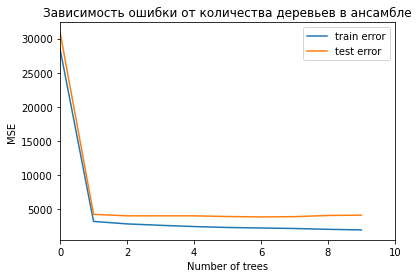

In [13]:
get_error_from_trees_plot(n_trees, train_errors, test_errors)

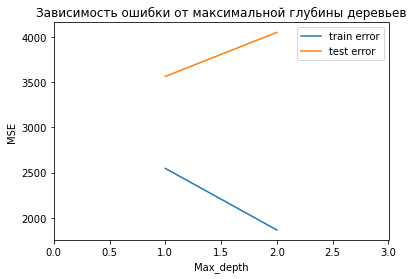

In [14]:
get_error_from_max_depth_plot(max_depth, train_errors_arr, test_errors_arr)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [15]:
%%time
n_trees = 50

train_errors_arr = []
test_errors_arr = []

for i in list(range(1, max_depth)):
    trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_err = mean_squared_error(y_train, train_prediction)
    test_err = mean_squared_error(y_test, test_prediction)
    train_errors_arr.append(train_err)
    test_errors_arr.append(test_err)

CPU times: user 32.6 s, sys: 196 ms, total: 32.8 s
Wall time: 32.8 s


In [16]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 1 на тренировочной выборке: 1863.6498144999036
Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 1 на тестовой выборке: 4054.810382119961


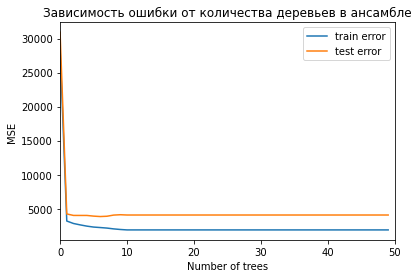

In [17]:
get_error_from_trees_plot(n_trees, train_errors, test_errors)

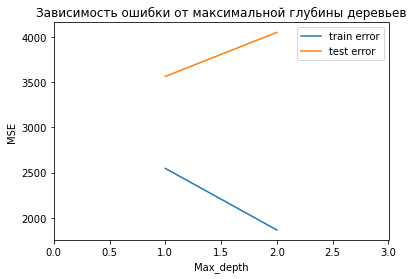

In [18]:
get_error_from_max_depth_plot(max_depth, train_errors_arr, test_errors_arr)

Теперь попробуем уменьшить шаг.

In [19]:
%%time
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

CPU times: user 16 s, sys: 7.96 ms, total: 16 s
Wall time: 16 s


In [20]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 0.1 на тренировочной выборке: 5542.587215495366
Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 0.1 на тестовой выборке: 7061.663877267085


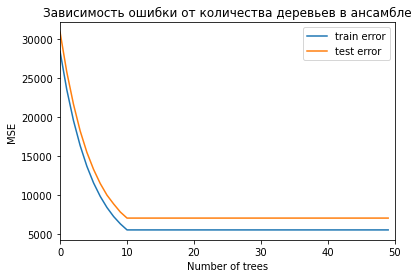

In [21]:
get_error_from_trees_plot(n_trees, train_errors, test_errors)

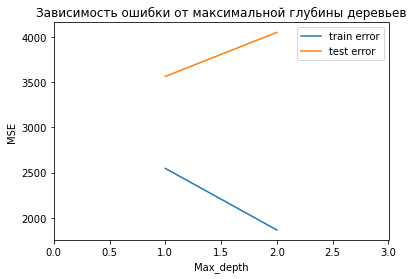

In [22]:
get_error_from_max_depth_plot(max_depth, train_errors_arr, test_errors_arr)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [23]:
%%time
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

CPU times: user 15.8 s, sys: 3.96 ms, total: 15.8 s
Wall time: 15.8 s


In [24]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 0.01 на тренировочной выборке: 23761.591936719135
Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 0.01 на тестовой выборке: 26058.768508900077


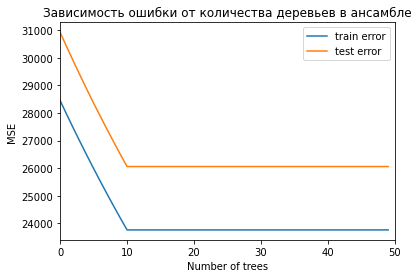

In [25]:
get_error_from_trees_plot(n_trees, train_errors, test_errors)

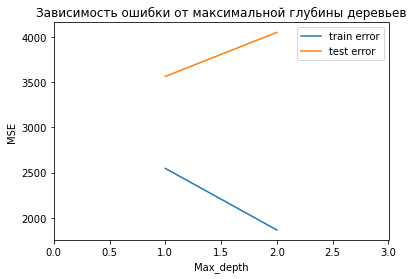

In [26]:
get_error_from_max_depth_plot(max_depth, train_errors_arr, test_errors_arr)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [27]:
%%time
eta = 0.1
max_depth = 5

train_errors_arr = []
test_errors_arr = []

for i in list(range(1, max_depth)):
    trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_err = mean_squared_error(y_train, train_prediction)
    test_err = mean_squared_error(y_test, test_prediction)
    train_errors_arr.append(train_err)
    test_errors_arr.append(test_err)

CPU times: user 1min 2s, sys: 60 ms, total: 1min 2s
Wall time: 1min 2s


In [28]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 0.1 на тренировочной выборке: 5033.265413737119
Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 0.1 на тестовой выборке: 7017.440462176995


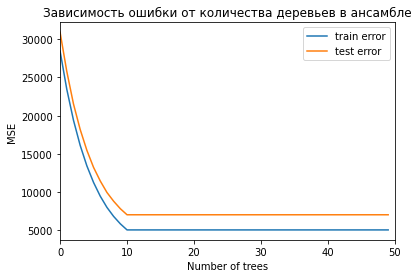

In [29]:
get_error_from_trees_plot(n_trees, train_errors, test_errors)

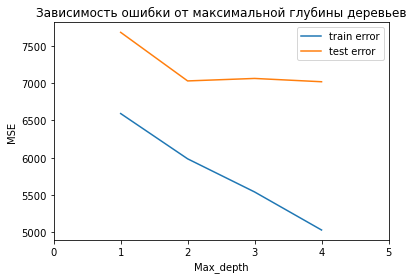

In [30]:
get_error_from_max_depth_plot(max_depth, train_errors_arr, test_errors_arr)

Ошибка на обучающей выборке упала, а на тестовой несколько поднялась, то есть в данном случае можем говорить о появлении переобучения.  
Ошибка на тренировочной выборке уменьшается при увеличении глубины дерева, но на тестовой выборке начинает расти или изменяется незначительно после 2.